In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from strategy import Strategy
from data_manager import DataManager

In [3]:
# Let's create fake "News Data" for NVIDIA for the last 6 months to test the engine.
print("Generating Mock Historical Data for Testing...")

dates = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
mock_news = pd.DataFrame({
    'Ticker': 'NVDA',
    'Date': dates,
    'Time': '09:00AM',
    'Headline': 'Mock Headline',
    # Random sentiment between -1 and 1
    'Sentiment_Score': np.random.uniform(-0.8, 0.8, size=len(dates)) 
})

Generating Mock Historical Data for Testing...


In [8]:
import yfinance as yf
#  --- 1. PERFECT PREDICTION MOCK DATA ---
print("Generating 'Perfect' Historical Data for Testing...")

# Download actual NVDA prices first so we can 'cheat'
prices = yf.download('NVDA', start='2023-01-01', end='2023-12-31', progress=False)
if isinstance(prices.columns, pd.MultiIndex): prices.columns = prices.columns.get_level_values(0)

# Create a news dataframe aligned with price moves
mock_news_list = []

for date, row in prices.iterrows():
    daily_return = (row['Close'] - row['Open']) / row['Open']
    
    # CHEAT CODE: 
    # If price went UP, generate POSITIVE sentiment.
    # If price went DOWN, generate NEGATIVE sentiment.
    if daily_return > 0.01: # > 1% gain
        score = 0.9
        headline = "NVIDIA discovers infinite money glitch"
    elif daily_return < -0.01: # > 1% loss
        score = -0.9
        headline = "NVIDIA factory explodes"
    else:
        score = 0.0
        headline = "Nothing happened"
        
    mock_news_list.append({
        'Ticker': 'NVDA',
        'Date': date,
        'Time': '09:00AM',
        'Headline': headline,
        'Sentiment_Score': score
    })

mock_news = pd.DataFrame(mock_news_list)
print(f"Created {len(mock_news)} perfect sentiment records.")

Generating 'Perfect' Historical Data for Testing...


C:\Users\jaygu\AppData\Local\Temp\ipykernel_5540\3882907380.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download('NVDA', start='2023-01-01', end='2023-12-31', progress=False)


Created 250 perfect sentiment records.


In [4]:
mask = (mock_news['Date'] > '2023-01-01') & (mock_news['Date'] < '2023-06-01')
mock_news.loc[mask, 'Sentiment_Score'] += 0.3 # Bias towards positive

In [9]:
print("\n--- RUNNING STRATEGY ---")
strat = Strategy(ticker='NVDA', sentiment_df=mock_news)
results = strat.run_backtest()


--- RUNNING STRATEGY ---


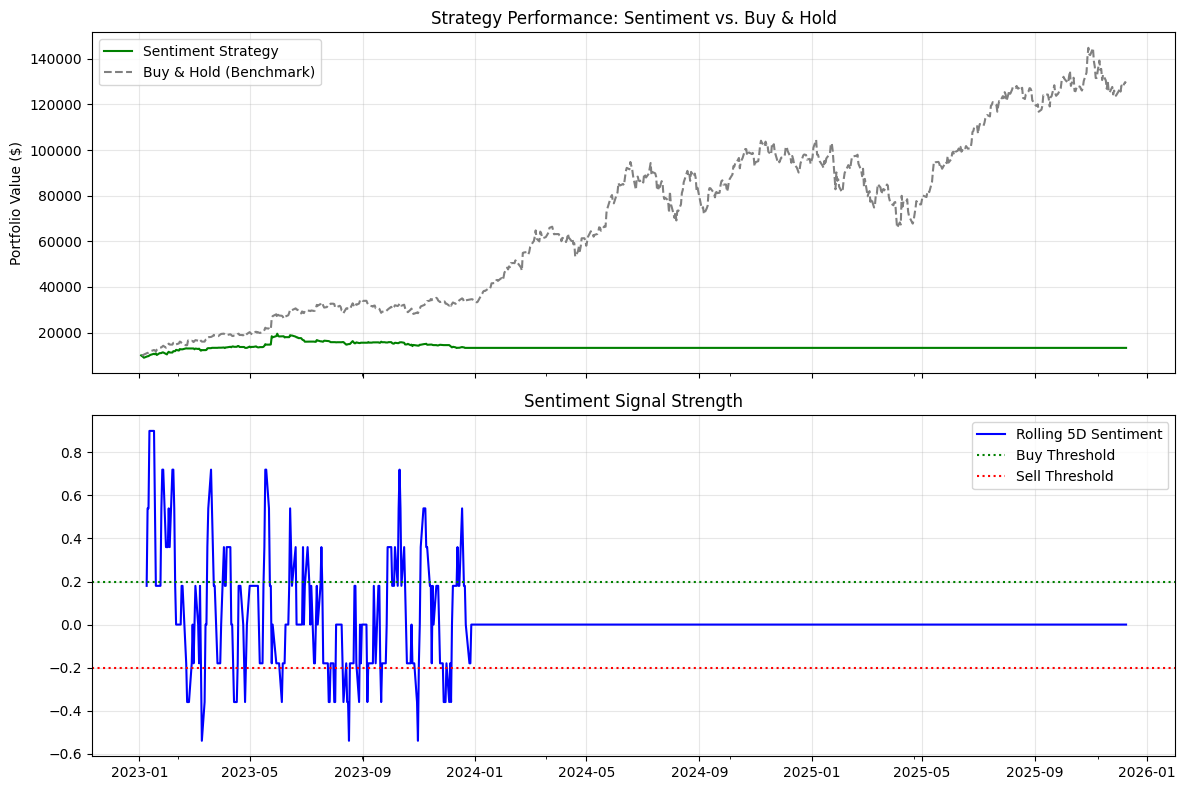

Total Profit: $3295.68


In [10]:
plt.figure(figsize=(12, 8))
# Plot 1: Equity Curve
ax1 = plt.subplot(2, 1, 1)
results['Cumulative_Return'].plot(ax=ax1, color='green', label='Sentiment Strategy')
benchmark = (1 + results['Daily_Return']).cumprod() * 10000
benchmark.plot(ax=ax1, color='gray', linestyle='--', label='Buy & Hold (Benchmark)')

ax1.set_title("Strategy Performance: Sentiment vs. Buy & Hold")
ax1.set_ylabel("Portfolio Value ($)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Sentiment vs Signal
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
results['Sentiment_Score'].rolling(5).mean().plot(ax=ax2, color='blue', label='Rolling 5D Sentiment')
ax2.axhline(0.2, color='green', linestyle=':', label='Buy Threshold')
ax2.axhline(-0.2, color='red', linestyle=':', label='Sell Threshold')
ax2.set_title("Sentiment Signal Strength")
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

total_ret = results['Cumulative_Return'].iloc[-1] - 10000
print(f"Total Profit: ${total_ret:.2f}")